In [1]:
from gensim.models import Word2Vec
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score
import numpy as np
import pandas as pd
import ast
import random
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

import spacy
nlp = spacy.load("en_core_web_sm")

import warnings
warnings.filterwarnings("ignore")

/home/aryanrr/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


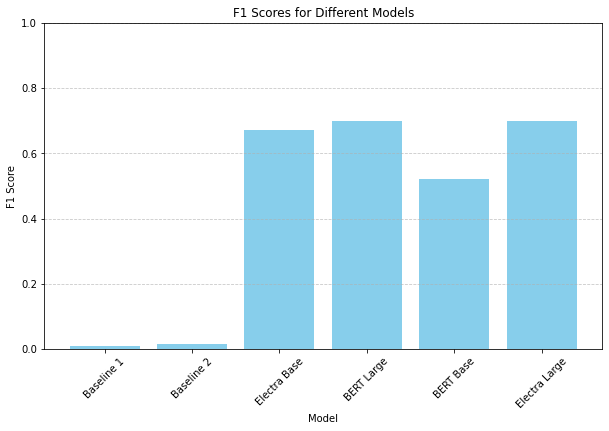

In [2]:
f1_scores = {
    "Baseline 1": 0.01,
    "Baseline 2": 0.016,
    "Electra Base": 0.67,
    "BERT Large": 0.7,
    "BERT Base": 0.52,
    "Electra Large": 0.7
}

# Plot F1 scores
plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue', alpha=1)
plt.title('F1 Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0, 1)  # Set y-axis limits
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [3]:
random.seed(630)

In [4]:
train_df = pd.read_csv("630_train_predictions.csv")
val_df = pd.read_csv("630_val_predictions.csv")
test_df = pd.read_csv("630_test_predictions.csv")

In [5]:
val_df.head()

,id,tokens,labels,predicted_labels,predicted_entities
0,0,['Somatic' 'cell' 'selection' 'major' 'determi...,[0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, ...","['dehydrogenase', 'severe enzyme deficiency', ..."
1,1,['ataxia' 'telangiectasia' 'gene' 'product' 'c...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[]
2,2,['Molecular' 'basis' 'Duarte' 'Los' 'Angeles' ...,[0 0 1 0 0 2 2 0 0 0 1 2 2 2 0 0 0 0 0 0 0 0 0...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","['galactosemia', 'galactosemia', 'galactosemia']"
3,3,['intronic' 'mutation' 'lariat' 'branchpoint' ...,[0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, ...","['disease', 'eye disease', 'FED', 'FED', 'FED']"
4,4,['Genetic' 'heterogeneity' 'hereditary' 'breas...,[0 0 1 2 2 0 0 1 0 2 2 0 0 0 0 0 0 0 1 2 2 0 0...,"[0, 0, 1, 2, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, ...","['hereditary breast cancer', 'hereditary', 'br..."


In [6]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(593, 5)
(100, 5)
(100, 5)


In [7]:
train_df['predicted_entities'] = train_df['predicted_entities'].apply(ast.literal_eval)
val_df['predicted_entities'] = val_df['predicted_entities'].apply(ast.literal_eval)
test_df['predicted_entities'] = test_df['predicted_entities'].apply(ast.literal_eval)

# Clustering

In [8]:
all_entities_train = list(set([entity for sublist in train_df['predicted_entities'] for entity in sublist]))
all_entities_val = list(set([entity for sublist in val_df['predicted_entities'] for entity in sublist]))
all_entities_test = list(set([entity for sublist in test_df['predicted_entities'] for entity in sublist]))

unique_entities = []
unique_entities.extend(all_entities_train)
unique_entities.extend(all_entities_val)
unique_entities.extend(all_entities_test)

In [9]:
len(unique_entities)

1856

In [10]:
def preprocess_text(text):
    doc = nlp(text.lower())
    processed_text = " ".join(token.lemma_ for token in doc if not token.is_stop and token.is_alpha)
    return processed_text

In [11]:
unique_entities = [preprocess_text(entity) for entity in unique_entities]

In [12]:
unique_entities = list(set(unique_entities))
len(unique_entities)

1374

In [13]:
word2vec_model = Word2Vec([unique_entities], vector_size=100, window=5, min_count=1, sg=1)

In [14]:
word_vectors = [word2vec_model.wv[word] for word in unique_entities]

In [15]:
scores = {
    'baseline_1': -0.014,
    'baseline_2': -0.014,
}

## Agglomerative

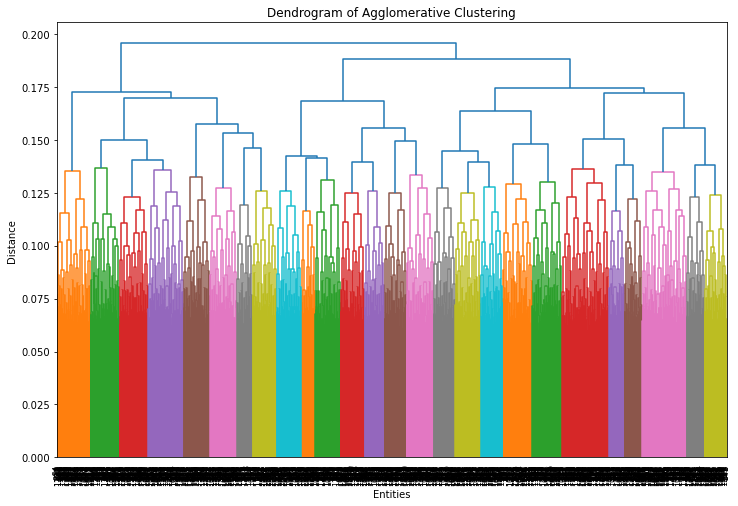

In [16]:
linkage_matrix = linkage(word_vectors, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram of Agglomerative Clustering')
plt.xlabel('Entities')
plt.ylabel('Distance')
plt.show()

In [17]:
# Define the range of values for n_clusters
min_clusters = 2
max_clusters = 20
cluster_range = range(min_clusters, max_clusters + 1)

# Initialize variables to store the best silhouette score and corresponding number of clusters
best_silhouette_score = -1
best_n_clusters = None

# Iterate over the range of values for n_clusters
for n_clusters in cluster_range:
    # Fit Agglomerative Clustering with the current number of clusters
    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(word_vectors)
    
    # Predict cluster labels
    cluster_labels = clustering.labels_
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(word_vectors, cluster_labels)
    
    # Update best silhouette score and corresponding number of clusters if current score is higher
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

# Print the best number of clusters
print(f"Best number of clusters: {best_n_clusters}, Best silhouette score: {best_silhouette_score}")

Best number of clusters: 2, Best silhouette score: 0.0038129277527332306


In [18]:
n_clusters = 2
clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(word_vectors)

In [19]:
cluster_labels = clustering.labels_
entity_cluster_map = {entity: cluster_labels[i] for i, entity in enumerate(unique_entities)}

In [20]:
for cluster_id in range(n_clusters):
    cluster_entities = [entity for entity, label in entity_cluster_map.items() if label == cluster_id]
    random.shuffle(cluster_entities)
    num_members_to_print = min(10, len(cluster_entities))
    
    print(f"Cluster {cluster_id+1}:")
    for entity in cluster_entities[:num_members_to_print]:
        print("\t", entity)
    print()

Cluster 1:
	 dihydropyrimidine dehydrogenase
	 gingival overgrowth
	 hypobetalipoproteinemia
	 color vision
	 cerebrotendinous xanthomatosis
	 breast cancer
	 rectum
	 isolate aniridia
	 cld
	 lupus

Cluster 2:
	 coenzyme dehydrogenase
	 cancer
	 familial amyloidotic polyneuropathy
	 becker muscular dystrophy
	 thrombosis
	 pc
	 episodic ataxia
	 myasthenia gravis
	 meningococcal disease
	 tumour



In [21]:
silhouette_avg = silhouette_score(word_vectors, clustering.labels_)
scores['Agglomerative'] = round(silhouette_avg, 3)

## KMeans

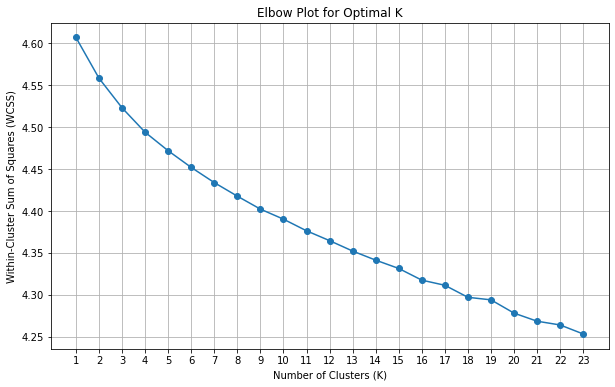

In [22]:
wcss = []
max_k = 23
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, init = 'random', random_state=42)
    kmeans.fit(word_vectors)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='-')
plt.title('Elbow Plot for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, max_k + 1))
plt.grid(True)
plt.show()

In [23]:
# Define the range of values for n_clusters
min_clusters = 2
max_clusters = 20
cluster_range = range(min_clusters, max_clusters + 1)

# Initialize variables to store the best silhouette score and corresponding number of clusters
best_silhouette_score = -1
best_n_clusters = None

# Iterate over the range of values for n_clusters
for n_clusters in cluster_range:
    # Fit K-means clustering with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters,  init = 'random', random_state=42)
    kmeans.fit(word_vectors)
    
    # Predict cluster labels
    cluster_labels = kmeans.labels_
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(word_vectors, cluster_labels)
    
    # Update best silhouette score and corresponding number of clusters if current score is higher
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

# Print the best number of clusters
print(f"Best number of clusters: {best_n_clusters}, Best silhouette score: {best_silhouette_score}")

Best number of clusters: 2, Best silhouette score: 0.009805851615965366


In [24]:
optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k,  init = 'random', random_state=42)
kmeans.fit(word_vectors)

KMeans(init='random', n_clusters=2, random_state=42)

In [25]:
silhouette_avg = silhouette_score(word_vectors, kmeans.labels_)
scores['KMeans'] = round(silhouette_avg, 3)

## KMeans++

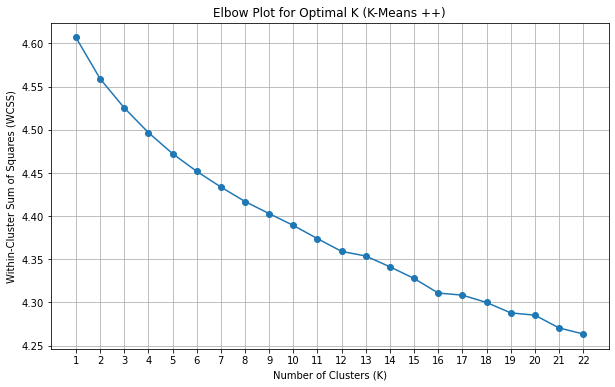

In [26]:
wcss = []
max_k = 22
for k in range(1, max_k + 1):
    kmeans_plus = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans_plus.fit(word_vectors)
    wcss.append(kmeans_plus.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='-')
plt.title('Elbow Plot for Optimal K (K-Means ++)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, max_k + 1))
plt.grid(True)
plt.show()

In [27]:
# Define the range of values for n_clusters
min_clusters = 2
max_clusters = 25
cluster_range = range(min_clusters, max_clusters + 1)

# Initialize variables to store the best silhouette score and corresponding number of clusters
best_silhouette_score = -1
best_n_clusters = None

# Iterate over the range of values for n_clusters
for n_clusters in cluster_range:
    # Fit KMeans clustering with k-means++ initialization and the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(word_vectors)
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(word_vectors, cluster_labels)
    
    # Update best silhouette score and corresponding number of clusters if current score is higher
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

# Print the best number of clusters
print(f"Best number of clusters: {best_n_clusters}, Best silhouette score: {best_silhouette_score}")


Best number of clusters: 2, Best silhouette score: 0.00957130454480648


In [28]:
optimal_k = 2

kmeans_plus = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans_plus.fit(word_vectors)

KMeans(n_clusters=2, random_state=42)

In [29]:
silhouette_avg = silhouette_score(word_vectors, kmeans_plus.labels_)
scores['KMeans++'] = round(silhouette_avg, 3)

## GMM

In [30]:
min_clusters = 2
max_clusters = 25
cluster_range = range(min_clusters, max_clusters + 1)

best_silhouette_score = -1
best_n_clusters = None

for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(word_vectors)
    
    cluster_labels = gmm.predict(word_vectors)
    silhouette_avg = silhouette_score(word_vectors, cluster_labels)
    
#     print(f"Number of clusters: {n_clusters}, Silhouette score: {silhouette_avg}")
    
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

print(f"Best number of clusters: {best_n_clusters}, Best silhouette score: {best_silhouette_score}")

Best number of clusters: 6, Best silhouette score: 0.008367188274860382


In [31]:
n_clusters = 2

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(word_vectors)
gmm_cluster_labels = gmm.predict(word_vectors)

In [32]:
silhouette_avg = silhouette_score(word_vectors, gmm_cluster_labels)
scores['GMM'] = round(silhouette_avg, 3)

# Performance Comparison

In [33]:
scores

{'baseline_1': -0.014,
 'baseline_2': -0.014,
 'Agglomerative': 0.004,
 'KMeans': 0.01,
 'KMeans++': 0.01,
 'GMM': 0.008}

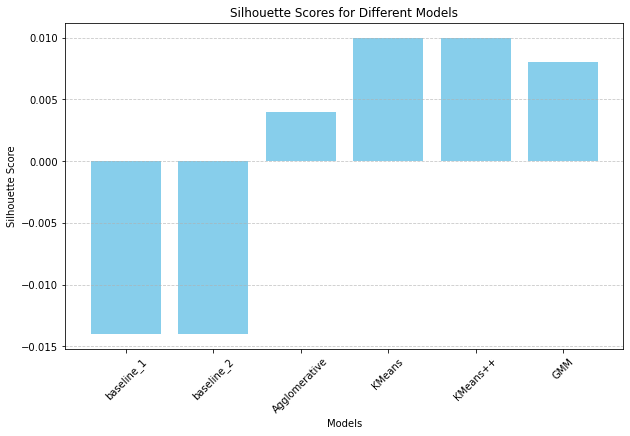

In [34]:
labels = list(scores.keys())
values = list(scores.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue', alpha=1)
plt.xlabel('Models')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()